<a href="https://colab.research.google.com/github/divyam63/Sarcasm_Model/blob/main/SarcasmDetectionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
import torch

In [4]:
csv_path = "/content/file.csv"
df = pd.read_csv(csv_path)

# Get the actual column names from the DataFrame
columns_to_drop = [col for col in ["Unnamed: 2", "Unnamed: 3"] if col in df.columns]

# Drop only the columns that exist
df = df.drop(columns=columns_to_drop)
df_majority = df[df['label'] == 0]
df_minority = df[df['label'] == 1]
plt.figure(figsize=(8, 6))

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

        Unnamed: 0  Unnamed: 1  \
2              NaN         NaN   
4              NaN         NaN   
5              NaN         NaN   
6              NaN         NaN   
8              NaN         NaN   
...            ...         ...   
115748         NaN         NaN   
101071         NaN         NaN   
175076         NaN         NaN   
24232          NaN         NaN   
21742          NaN         NaN   

                                                     text  label  
2        Please Avail the Covid-19 Vaccine on control ...      0  
4       The Draconian Machinations of Evil Republicans...      0  
5        one of the first lawsuits against 🇨🇳 for the ...      0  
6        As u mentioned in last speech micro containme...      0  
8       Stay alert with Omnicron Varient, stay protect...      0  
...                                                   ...    ...  
115748  POTUS et. al has worked hard to ensure there i...      1  
101071   Great. This option is very Good in means of r.

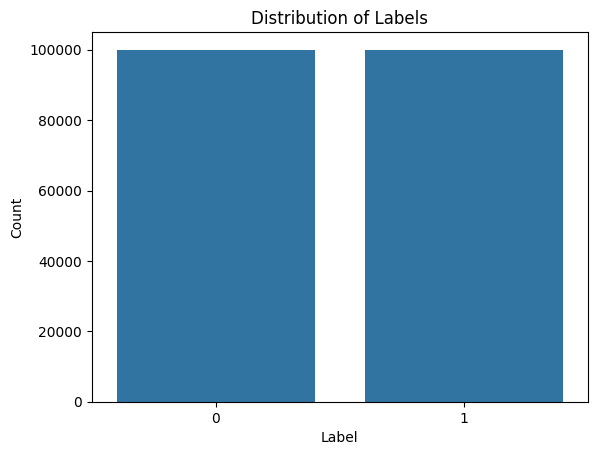

In [6]:
df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=42)

df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Split data into features (X) and labels (y)
X = df_upsampled['text'].values
y = df_upsampled['label'].values
sns.countplot(x='label', data=df_upsampled)
print(df_upsampled)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')

# Show the plot
plt.show()

In [7]:
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
max_length = 128  # Set the maximum sequence length for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
X_train_encoded = tokenizer.batch_encode_plus(
    X_train.tolist(),
    add_special_tokens=True,
    max_length=max_length,
    return_attention_mask=True,
    return_tensors='tf',
    pad_to_max_length=True,
    truncation=True
)
X_test_encoded = tokenizer.batch_encode_plus(
    X_test.tolist(),
    add_special_tokens=True,
    max_length=max_length,
    return_attention_mask=True,
    return_tensors='tf',
    pad_to_max_length=True,
    truncation=True
)

# Define class weights for handling imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [10]:
embedding_dim = 100
lstm_units = 128

input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=len(tokenizer.get_vocab()), output_dim=embedding_dim, input_length=max_length)(input_layer)
bi_lstm_layer = Bidirectional(LSTM(lstm_units))(embedding_layer)
dropout_layer = Dropout(0.5)(bi_lstm_layer)
output_layer = Dense(1, activation='sigmoid')(dropout_layer)

bi_lstm_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the Bi-LSTM model
bi_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the Bi-LSTM model
bi_lstm_model.fit(X_train_encoded['input_ids'], y_train, epochs=1, batch_size=64, class_weight=class_weight_dict)

# Evaluate the Bi-LSTM model
bi_lstm_loss, bi_lstm_accuracy = bi_lstm_model.evaluate(X_test_encoded['input_ids'], y_test)

print("Bi-LSTM Model - Loss:", bi_lstm_loss)
print("Bi-LSTM Model - Accuracy:", bi_lstm_accuracy)

2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1319s 600ms/step - accuracy: 0.6913 - loss: 0.5674
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 224s 119ms/step - accuracy: 0.7886 - loss: 0.4533
Bi-LSTM Model - Loss: 0.4534052610397339
Bi-LSTM Model - Accuracy: 0.7875499725341797


In [17]:
import joblib

# Load the pre-trained model
loaded_model = joblib.load('bi_lstm_model.joblib')  # Replace 'bi_lstm_model.joblib' with the actual file name

# Now you can use loaded_model for predictions
# For example:


# Save the model
joblib.dump(bi_lstm_model, 'bi_lstm_model.joblib')

# Load the model
loaded_model = joblib.load('bi_lstm_model.joblib')


# Save the model using joblib
joblib.dump(bi_lstm_model, 'bi_lstm_model.joblib')
loaded_model = joblib.load('bi_lstm_model.joblib')  # Replace with the actual file name


In [ ]:
y_pred = loaded_model.predict(X_test_encoded['input_ids'])
y_pred_labels = (y_pred > 0.5).astype(int)

# Print some evaluation metrics (e.g., accuracy)
accuracy = accuracy_score(y_test, y_pred_labels)
print("Testing Accuracy:", accuracy)
f1 = f1_score(y_test, y_pred_labels)
print("Testing F1 Score:", f1)
cm=confusion_matrix(y_test,y_pred_labels)
print(classification_report(y_test,y_pred_labels))
print("The Accuracy is",accuracy_score(y_test,y_pred_labels))
sns.heatmap(cm,annot=True)

 592/1875 ━━━━━━━━━━━━━━━━━━━━ 2:33 120ms/step

In [11]:
def preprocess_input(input_text):
    blob = TextBlob(input_text)
    sentiment_scores = [sentence.sentiment.polarity for sentence in blob.sentences]
    return sentiment_scores

In [12]:
def classify_sentiment_shifts(sentiment_scores): # Sentimental Scores:
    positive_count=0
    negative_count=0
    flag=0;
    prev_sentiment = sentiment_scores[0]
    for sentiment in sentiment_scores[1:]:

        if prev_sentiment > 0 and sentiment>=0 :
            positive_count=positive_count+1
        elif prev_sentiment >0 and sentiment<= 0:
            negative_count=negative_count+1
            prev_sentiment=sentiment
            flag=1;
            continue
        elif prev_sentiment< 0 and sentiment <=0 and flag==1:
            negative_count=negative_count+1
        elif prev_sentiment < 0 and sentiment >=0 and flag==1:
            positive_count=positive_count+1
        prev_sentiment=sentiment
    if positive_count > negative_count or negative_count > positive_count:
        return 0
    elif positive_count ==0 and negative_count==0:
        return 0
    else:
        return 1

In [13]:
def classify_using_lstm(input_text):
    sentiment_scores = preprocess_input(input_text)
    classification = classify_sentiment_shifts(sentiment_scores)

    return classification

def classify_sarcasm_with_lstm(input_text):
    input_encoded = tokenizer.encode_plus(
        input_text,
        add_special_tokens=True,
        max_length=max_length,
        return_attention_mask=True,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

    prediction = bi_lstm_model.predict(input_encoded['input_ids'])
    prediction_label = 1 if prediction > 0.7 else 0

    return prediction_label

In [14]:
!python -m textblob.download_corpora

user_input = input("Enter a text: ")
lstm_classification = classify_using_lstm(user_input)
print(lstm_classification)
if lstm_classification == 0:
    print("Non-sarcastic (From Sentimental Score)")
elif lstm_classification == 1:
    print("Sarcastic (From Sentimental Score)")
lstm_sarcasm_classification = classify_sarcasm_with_lstm(user_input)
if lstm_sarcasm_classification == 1:
    print("Sarcastic (Using BiLSTM)")
else:
    print("Non-sarcastic (Using BiLSTM)")
print("User Input:", user_input)

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.
Enter a text: sarcasm
0
Non-sarcastic (From Sentimental Score)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
Sarcastic (Using BiLSTM)
User Input: sarcasm


In [15]:
!pip install transformers

In [19]:
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertModel

# Load DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

# ... (Rest of your code for data preprocessing and model building)

# Define the model input
input_ids = Input(shape=(max_length,), dtype=tf.int32)
attention_mask = Input(shape=(max_length,), dtype=tf.int32)

# Wrap the BERT model call in a function
def get_embeddings(input_ids, attention_mask):
    return bert_model(input_ids, attention_mask=attention_mask)[0]

# Create a Lambda layer to call the function, specifying the output shape
embeddings = tf.keras.layers.Lambda(
    get_embeddings,
    output_shape=(max_length, bert_model.config.hidden_size)  # Specify the output shape
)([input_ids, attention_mask])

# ... (Rest of your model architecture)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [20]:
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertModel
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

# Load DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

# Define the model input
max_length = 128  # Adjust as needed
input_ids = Input(shape=(max_length,), dtype=tf.int32)
attention_mask = Input(shape=(max_length,), dtype=tf.int32)

# Wrap the BERT model call in a function
def get_embeddings(input_ids, attention_mask):
    return bert_model(input_ids, attention_mask=attention_mask)[0]

# Create a Lambda layer to call the function, specifying the output shape
embeddings = tf.keras.layers.Lambda(
    get_embeddings,
    output_shape=(max_length, bert_model.config.hidden_size)
)([input_ids, attention_mask])

# Add classification layers on top of BERT embeddings
x = tf.keras.layers.GlobalAveragePooling1D()(embeddings)  # Pool embeddings
x = Dense(64, activation='relu')(x)  # Intermediate dense layer
x = Dropout(0.2)(x)  # Dropout for regularization
output = Dense(1, activation='sigmoid')(x)  # Output layer for binary classification

# Create the model
distilbert_classifier = Model(inputs=[input_ids, attention_mask], outputs=output)

# Compile the model
distilbert_classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
distilbert_classifier.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_10      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 128, 768)  │          0 │ input_layer_9[0]… │
│                     │                   │            │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 768)       │          0 │ lambda_3[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     49,216 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 49,281 (192.50 KB)

 Trainable params: 49,281 (192.50 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:
import joblib

# ... (other imports and functions)

# Load the Bi-LSTM model before using it
loaded_bi_lstm_model = joblib.load('bilstm_model.joblib')  # Replace 'bi_lstm_model.joblib' with the actual file name


# Classification Functions
def preprocess_input(input_text):
    blob = TextBlob(input_text)
    sentiment_scores = [sentence.sentiment.polarity for sentence in blob.sentences]
    return sentiment_scores

def classify_sentiment_shifts(sentiment_scores):
    positive_count = 0
    negative_count = 0
    flag = 0
    prev_sentiment = sentiment_scores[0]
    for sentiment in sentiment_scores[1:]:
        if prev_sentiment > 0 and sentiment >= 0:
            positive_count += 1
        elif prev_sentiment > 0 and sentiment <= 0:
            negative_count += 1
            prev_sentiment = sentiment
            flag = 1
            continue
        elif prev_sentiment < 0 and sentiment <= 0 and flag == 1:
            negative_count += 1
        elif prev_sentiment < 0 and sentiment >= 0 and flag == 1:
            positive_count += 1
        prev_sentiment = sentiment
    if positive_count > negative_count or negative_count > positive_count:
        return 0
    elif positive_count == 0 and negative_count == 0:
        return 0
    else:
        return 1

def classify_using_lstm(input_text):
    sentiment_scores = preprocess_input(input_text)
    classification = classify_sentiment_shifts(sentiment_scores)
    return classification

def classify_sarcasm_with_lstm(input_text):
    input_encoded = tokenizer.encode_plus(
        input_text,
        add_special_tokens=True,
        max_length=max_length,
        return_attention_mask=True,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )
    prediction = loaded_bi_lstm_model.predict(input_encoded['input_ids'])  # Use loaded model
    prediction_label = 1 if prediction > 0.7 else 0  # Adjust threshold if needed
    return prediction_label

def classify_sarcasm_with_distilbert(input_text):
    # Use the existing 'tokenizer' instead of 'distilbert_tokenizer'
    input_encoded = tokenizer.encode_plus(
        input_text,
        add_special_tokens=True,
        max_length=max_length,
        return_attention_mask=True,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )
    # Pass input_ids and attention_mask as separate keyword arguments
    prediction = distilbert_classifier.predict({
        'input_ids': input_encoded['input_ids'],
        'attention_mask': input_encoded['attention_mask']
    })
    prediction_label = 1 if prediction > 0.5 else 0  # Adjust threshold if needed
    return prediction_label


# Get user input and classify
user_input = input("Enter a text: ")

# Classify using Bi-LSTM
lstm_classification = classify_using_lstm(user_input)
if lstm_classification == 0:
    print("Non-sarcastic (From Sentimental Score)")
elif lstm_classification == 1:
    print("Sarcastic (From Sentimental Score)")
lstm_sarcasm_classification = classify_sarcasm_with_lstm(user_input)
if lstm_sarcasm_classification == 1:
    print("Sarcastic (Using BiLSTM)")
else:
    print("Non-sarcastic (Using BiLSTM)")

# Classify using DistilBERT
distilbert_classification = classify_sarcasm_with_distilbert(user_input)
if distilbert_classification == 1:
    print("Sarcastic (Using DistilBERT)")
else:
    print("Non-sarcastic (Using DistilBERT)")

print("User Input:", user_input)

FileNotFoundError: [Errno 2] No such file or directory: 'bilstm_model.joblib'

# Task
load it

Here is all the data you need:
"Final2.csv"

## Data loading

### Subtask:
Load the two CSV files into pandas DataFrames.


**Reasoning**:
Load the two CSV files into pandas DataFrames.



In [1]:
import pandas as pd

try:
    df_final2 = pd.read_csv('Final2.csv', encoding='utf-8')
    df_combined = pd.read_csv('/content/combined_data[1].csv', encoding='utf-8')
except FileNotFoundError:
    print("One or both of the CSV files were not found.")
    df_final2 = None
    df_combined = None
except pd.errors.ParserError:
    print("Error parsing the CSV file. Please check the file format.")
    df_final2 = None
    df_combined = None
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    df_final2 = None
    df_combined = None

if df_final2 is not None:
  display(df_final2.head())
if df_combined is not None:
  display(df_combined.head())

One or both of the CSV files were not found.


**Reasoning**:
The previous attempt failed due to FileNotFoundError.  I will try again, but this time I will use a more robust error handling approach.  I'll also explicitly check for the existence of the files before trying to read them.



In [2]:
import os
import pandas as pd

file1 = 'Final2.csv'
file2 = '/content/combined_data[1].csv'

df_final2 = None
df_combined = None

if os.path.exists(file1):
    try:
        df_final2 = pd.read_csv(file1, encoding='utf-8')
        display(df_final2.head())
    except pd.errors.ParserError:
        print(f"Error parsing {file1}. Please check the file format.")
    except Exception as e:
        print(f"An unexpected error occurred while reading {file1}: {e}")
else:
    print(f"File not found: {file1}")

if os.path.exists(file2):
    try:
        df_combined = pd.read_csv(file2, encoding='utf-8')
        display(df_combined.head())
    except pd.errors.ParserError:
        print(f"Error parsing {file2}. Please check the file format.")
    except Exception as e:
        print(f"An unexpected error occurred while reading {file2}: {e}")
else:
    print(f"File not found: {file2}")

,label,text,Unnamed: 2,Unnamed: 3
0,0,Yawn..........: One of the least imaginative ...,NaN,NaN
1,0,"Truely Bad!: Three stories, by three fairly r...",NaN,NaN
2,0,Breathtaking. . . .An Unforgettable Film: Ver...,NaN,NaN
3,0,Drama Par Excellence: Having viewed this movi...,NaN,NaN
4,0,"WHAT a classic movie!: Excellent, superb phot...",NaN,NaN


File not found: /content/combined_data[1].csv


## Data exploration

### Subtask:
Explore the structure and contents of the loaded DataFrames, `df_final2` and `df_combined`, and identify common columns.


**Reasoning**:
Examine the structure, data types, and descriptive statistics of the loaded DataFrame `df_final2`, and identify potential issues.



In [3]:
# Check the shape of the DataFrame
print("Shape of df_final2:", df_final2.shape)

# Get data types and missing values
print("\nInfo of df_final2:")
display(df_final2.info())

# Descriptive statistics for numerical columns
print("\nDescriptive statistics of df_final2 (numerical):")
display(df_final2.describe())

# Descriptive statistics for non-numerical columns
print("\nDescriptive statistics of df_final2 (non-numerical):")
display(df_final2.describe(include='object'))

# Since there's only one dataframe loaded successfully, there are no common columns to identify.
print("\nNo common columns to identify, as only df_final2 was loaded successfully.")

# Initial observations
print("\nInitial Observations:")
print("1. The 'Unnamed: 2' and 'Unnamed: 3' columns appear to contain mostly missing values.")
print("2. The 'label' column is likely the target variable.")
print("3. The 'text' column contains the main textual data.")
print("4. Further investigation is needed to determine the meaning of the 'label' and its relation to the 'text' data.")

Shape of df_final2: (91030, 4)

Info of df_final2:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91030 entries, 0 to 91029
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   label       91030 non-null  int64 
 1   text        91030 non-null  object
 2   Unnamed: 2  8 non-null      object
 3   Unnamed: 3  2 non-null      object
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


None


Descriptive statistics of df_final2 (numerical):


,label
count,91030.000000
mean,0.069175
std,0.253753
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000



Descriptive statistics of df_final2 (non-numerical):


,text,Unnamed: 2,Unnamed: 3
count,91030,8,2
unique,90995,8,2
top,"'no way to prevent this,' says only nation whe...",=(,C.
freq,8,1,1



No common columns to identify, as only df_final2 was loaded successfully.

Initial Observations:
1. The 'Unnamed: 2' and 'Unnamed: 3' columns appear to contain mostly missing values.
2. The 'label' column is likely the target variable.
3. The 'text' column contains the main textual data.
4. Further investigation is needed to determine the meaning of the 'label' and its relation to the 'text' data.
